## Import all modules

In [1]:
# Import all the required packages
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
%matplotlib inline

## Load and explore data

Number of cars 8792
Number of noncars 8968
Car image shape (64, 64, 3)
Noncar image shape (64, 64, 3)


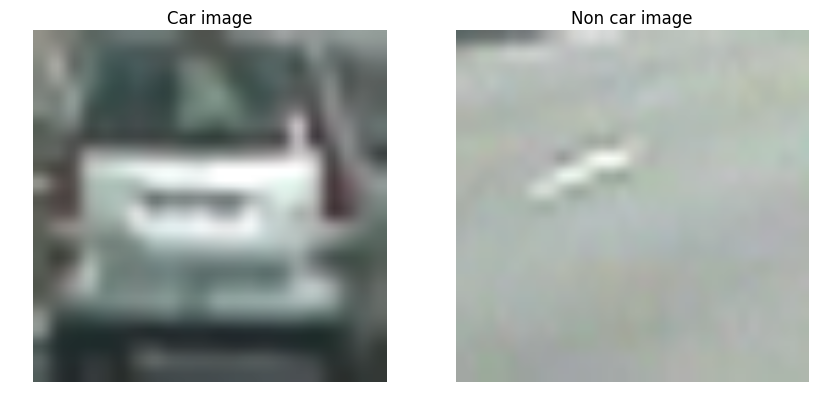

In [2]:
# Read in cars and notcars         
cars = glob.glob("vehicles/*/*/*.png")
notcars = glob.glob("non-vehicles/*/*/*.png")

# Do some data exploration
rand_car_ind = np.random.randint(0, len(cars))
rand_notcar_ind = np.random.randint(0, len(notcars))
print("Number of cars", len(cars))
print("Number of noncars", len(notcars))
print("Car image shape", mpimg.imread(cars[rand_car_ind]).shape)
print("Noncar image shape", mpimg.imread(notcars[rand_notcar_ind]).shape)

# Visualize an example car and noncar image
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,10))
ax1.imshow(cv2.cvtColor(cv2.imread(cars[rand_car_ind]), cv2.COLOR_BGR2RGB))
ax1.axis('off')
ax1.set_title("Car image")
ax2.imshow(cv2.cvtColor(cv2.imread(notcars[rand_notcar_ind]), cv2.COLOR_BGR2RGB))
ax2.axis('off')
ax2.set_title("Non car image")

## Functions to extract HOG, Spatial Binning, Color Histogram features

In [3]:
# Define a function to extract features from a list of images
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = cv2.imread(file)
        # apply color conversion if other than 'RGB'. I use BGR as I read images in OpenCV
        if color_space == 'RGB':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        elif color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
            
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features) 

            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Couple of useful functions mainly used for plotting    
def bgr2rgb(img) :
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def rgb2bgr(img) :
    return cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

## Feature Extraction and Optimum Classifier

### Exploring Histogram of Oriented Gradients (HOG) of the data set

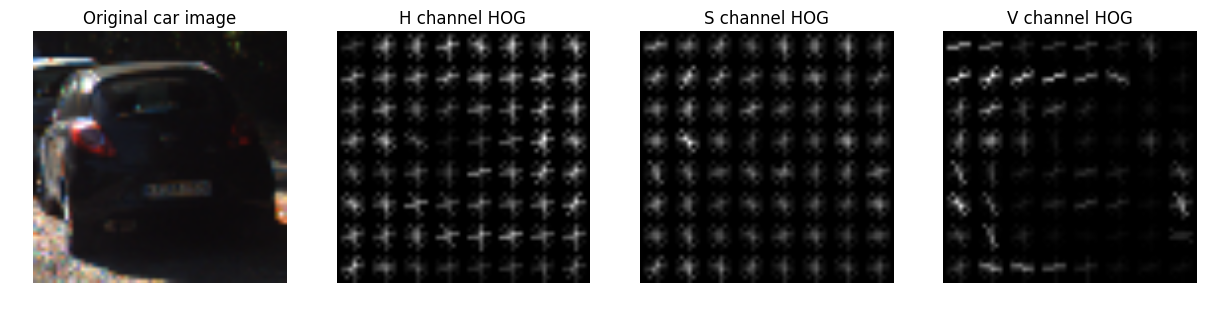

In [4]:
# Read in a random image
ind = np.random.randint(0, len(cars))
image = cv2.imread(cars[ind])
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

#Extract HOG visualizations for H, S, and V channels
hog_channel = 0 # H in HSV color space
features, hog_image_h = get_hog_features(hsv_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

hog_channel = 1 # S in HSV color space
features, hog_image_s = get_hog_features(hsv_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

hog_channel = 2 # V in HSV color space
features, hog_image_v = get_hog_features(hsv_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,figsize=(15,15))
ax1.imshow(bgr2rgb(image))
ax1.axis('off')
ax1.set_title("Original car image")
ax2.imshow(hog_image_h, cmap = 'gray')
ax2.axis('off')
ax2.set_title("H channel HOG")
ax3.imshow(hog_image_s, cmap = 'gray')
ax3.axis('off')
ax3.set_title("S channel HOG")
ax4.imshow(hog_image_v, cmap = 'gray')
ax4.axis('off')
ax4.set_title("V channel HOG")

### HOGs have several parameters to tune such as orientation, color spaces, number of pixels per cell, number of cells per block. In the following I first select the optimum pixels per cell between three options using SVM.

In [5]:
# Check for the best classifier with the following three pixels per cell options; I keep the other HOG parameters fixed
pix_per_cell_list = [8, 16, 32]
for pix_per_cell in pix_per_cell_list:
    color_space = 'HSV'
    orient = 9 # HOG orientation
    cell_per_block = 2 # HOG cells per block
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

    spatial_size = (32, 32) # Spatial binning dimensions - not used here
    hist_bins = 32    # Number of histogram bins - not used here
    spatial_feat = False # Spatial features on or off
    hist_feat = False # Histogram features on or off
    hog_feat = True # HOG features on or off

    car_features = extract_features(cars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

    X = np.vstack((car_features, notcar_features)).astype(np.float64) 
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training (80%) and test(20%) sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    #print(round(t2-t, 2), 'Seconds to train SVC...')
    print("Pixels per cell", pix_per_cell)
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    print("----------------------------")
    t=time.time()

Pixels per cell 8
Test Accuracy of SVC =  0.9837
----------------------------
Pixels per cell 16
Test Accuracy of SVC =  0.9778
----------------------------
Pixels per cell 32
Test Accuracy of SVC =  0.9645
----------------------------


### Based on the above result I select the 8 Pixels per cell option as it gives the best test accuracy. Now I'll check for the best cells per block value between two options

In [6]:
# Check for the best classifier with the following three pixels per cell options; I keep the other HOG parameters fixed
cell_per_block_list = [2, 4]
for cell_per_block in cell_per_block_list:
    color_space = 'HSV'
    orient = 9 # HOG orientation
    pix_per_cell = 8 # HOG pixels per cell
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

    spatial_size = (32, 32) # Spatial binning dimensions - not used here
    hist_bins = 32    # Number of histogram bins - not used here
    spatial_feat = False # Spatial features on or off
    hist_feat = False # Histogram features on or off
    hog_feat = True # HOG features on or off

    car_features = extract_features(cars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

    X = np.vstack((car_features, notcar_features)).astype(np.float64) 
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training (80%) and test(20%) sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    print("Cells per block", cell_per_block)
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    print("----------------------------")
    t=time.time()

18.3 Seconds to train SVC...
Cells per block 2
Test Accuracy of SVC =  0.9873
----------------------------
151.63 Seconds to train SVC...
Cells per block 4
Test Accuracy of SVC =  0.982
----------------------------


### I have selected the best Pixels per cell (8) and Cells per block (2) options. Now I'll check for the best Color space between six options 

In [7]:
# # Check for the best classifier with the following six color space options; I keep the other HOG parameters fixed
color_space_list = ['RGB', 'HSV', 'HLS', 'YCrCb', 'YUV', 'LUV']
for color_space in color_space_list:
    orient = 9  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

    spatial_size = (32, 32) # Spatial binning dimensions - not used here
    hist_bins = 32    # Number of histogram bins - not used here
    spatial_feat = False # Spatial features on or off
    hist_feat = False # Histogram features on or off
    hog_feat = True # HOG features on or off

    car_features = extract_features(cars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

    X = np.vstack((car_features, notcar_features)).astype(np.float64) 
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training (80%) and test (20%) sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    #print(round(t2-t, 2), 'Seconds to train SVC...')
    print("Color space and HOG channel", color_space, hog_channel)
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    print("----------------------------")
    t=time.time()

Color space and HOG channel RGB ALL
Test Accuracy of SVC =  0.9679
----------------------------
Color space and HOG channel HSV ALL
Test Accuracy of SVC =  0.9834
----------------------------
Color space and HOG channel HLS ALL
Test Accuracy of SVC =  0.9825
----------------------------
Color space and HOG channel YCrCb ALL
Test Accuracy of SVC =  0.9882
----------------------------
Color space and HOG channel YUV ALL
Test Accuracy of SVC =  0.9851
----------------------------
Color space and HOG channel LUV ALL
Test Accuracy of SVC =  0.9842
----------------------------


### I have selected the best Color space (YCrCb), Pixels per cell (8), and Cells per block (2) options. Now I'll check for the best Orientation between six options 

In [8]:
# Check for the best classifier with the following six orientation options; I keep the other HOG parameters fixed
orientation_list = [7, 8, 9, 10, 11, 12]
for orient in orientation_list:
    color_space = 'YCrCb'
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

    spatial_size = (32, 32) # Spatial binning dimensions - not used here
    hist_bins = 32    # Number of histogram bins - not used here
    spatial_feat = False # Spatial features on or off
    hist_feat = False # Histogram features on or off
    hog_feat = True # HOG features on or off

    car_features = extract_features(cars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

    X = np.vstack((car_features, notcar_features)).astype(np.float64) 
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training (80%) and test(20%) sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    print("Orientation", orient)
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    print("----------------------------")
    t=time.time()

12.34 Seconds to train SVC...
Orientation 7
Test Accuracy of SVC =  0.9834
----------------------------
13.1 Seconds to train SVC...
Orientation 8
Test Accuracy of SVC =  0.9854
----------------------------
16.45 Seconds to train SVC...
Orientation 9
Test Accuracy of SVC =  0.989
----------------------------
4.77 Seconds to train SVC...
Orientation 10
Test Accuracy of SVC =  0.9876
----------------------------
6.34 Seconds to train SVC...
Orientation 11
Test Accuracy of SVC =  0.989
----------------------------
25.56 Seconds to train SVC...
Orientation 12
Test Accuracy of SVC =  0.9876
----------------------------


### Finally I have selected the best Color space (YCrCb), Orientation (10), Pixels per cell (8), and Cells per block (2) for HOG parameters. Now I am checking for Spatial Binning and Histogram of color spaces to see if the test accuracy improves

In [9]:
color_space = 'YCrCb'
orient = 10
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                    spatial_size=spatial_size, hist_bins=hist_bins, 
                    orient=orient, pix_per_cell=pix_per_cell, 
                    cell_per_block=cell_per_block, 
                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
                    hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64) 
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training(80%) and test(20%) sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
print("YCrCb color space, 9 orientations, Spatial binning and Color histograms")
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
print("----------------------------")
t=time.time()

9.64 Seconds to train SVC...
YCrCb color space, 9 orientations, Spatial binning and Color histograms
Test Accuracy of SVC =  0.9924
----------------------------


## Finding cars, Drawing bounding boxes, Heatmaps, Thresholding

### Functions to find cars and draw bounding boxes around them. The above classifier (SVC) is used for prediction

In [10]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    # Array of bounding boxes where cars are detected
    bbox_list = []
    
    #draw_img = np.copy(img)
    #img = img.astype(np.float32)/255
    img_tosearch = img[ystart:ystop,:,:]
    
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb) 

    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))       
            test_prediction = svc.predict(test_features)          
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                bbox_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return bbox_list

### Example of finding cars and drawing bounding boxes around cars and within regions constrained along the y-axis

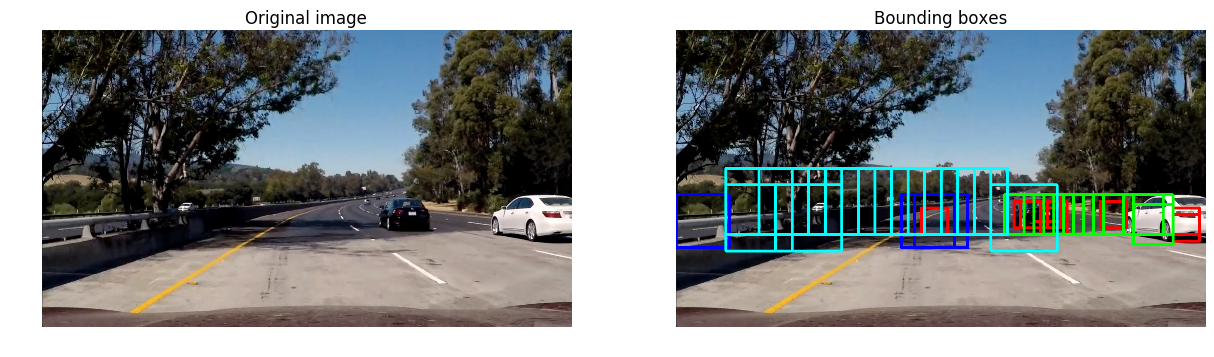

In [11]:
# Search for cars in four regions within a new image. No need to search at the top of the image (0 to 336) as there are only 
# buildings, bill boards, and trees
image = cv2.imread('test_images/test5.jpg')
draw_img = np.copy(image)
bbox_list = []

ystart = 400
ystop = 528
scale = 1.0
bbox_list.append(find_cars(draw_img, ystart, ystop, scale, svc, X_scaler, orient, 
                           pix_per_cell, cell_per_block, spatial_size, hist_bins))
draw_img = draw_boxes(image, bbox_list[0], color=(0, 0, 255), thick=6)

ystart = 400
ystop = 592
scale = 1.5
bbox_list.append(find_cars(draw_img, ystart, ystop, scale, svc, X_scaler, orient, 
                           pix_per_cell, cell_per_block, spatial_size, hist_bins))
draw_img = draw_boxes(draw_img, bbox_list[1], color=(0, 255, 0), thick=6)

ystart = 400
ystop = 656
scale = 2.0
bbox_list.append(find_cars(draw_img, ystart, ystop, scale, svc, X_scaler, orient, 
                           pix_per_cell, cell_per_block, spatial_size, hist_bins))
draw_img = draw_boxes(draw_img, bbox_list[2], color=(255, 0, 0), thick=6)

ystart = 336
ystop = 656
scale = 2.5
bbox_list.append(find_cars(draw_img, ystart, ystop, scale, svc, X_scaler, orient, 
                           pix_per_cell, cell_per_block, spatial_size, hist_bins))
draw_img = draw_boxes(draw_img, bbox_list[3], color=(255, 255, 0), thick=6)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,10))
ax1.imshow(bgr2rgb(image))
ax1.axis('off')
ax1.set_title("Original image")
ax2.imshow(bgr2rgb(draw_img))
ax2.axis('off')
ax2.set_title("Bounding boxes")

### As you see above there are too many false positives (bounding boxes around non-cars) and duplicates (multiple bounding boxes around cars). Through heatmaps and thresholding get rid off false positives and duplicate boxes

In [12]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,255,0), 6)
    # Return the image
    return img

### Example of finding cars, drawing bounding boxes, applying heatmaps and thresholding to reduce/eliminate false positives and duplicate boxes

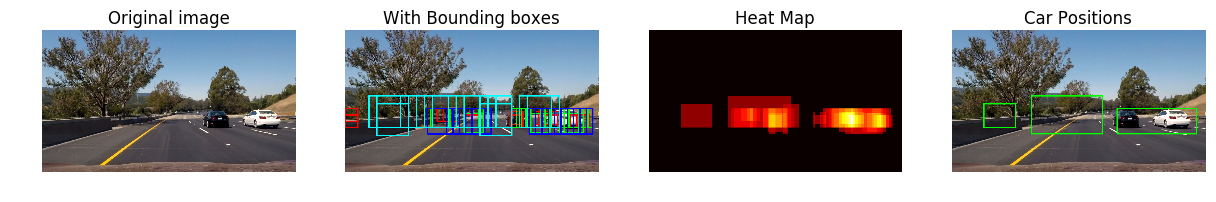

In [13]:
image = cv2.imread('test_images/test6.jpg')
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,figsize=(15,15))
ax1.imshow(bgr2rgb(image))
ax1.axis('off')
ax1.set_title("Original image")

draw_img = np.copy(image)
bbox_list = []

ystart = 400
ystop = 528
scale = 1.0
bbox_list.append(find_cars(draw_img, ystart, ystop, scale, svc, X_scaler, orient, 
                           pix_per_cell, cell_per_block, spatial_size, hist_bins))
draw_img = draw_boxes(image, bbox_list[0], color=(0, 0, 255), thick=6)

ystart = 400
ystop = 592
scale = 1.5
bbox_list.append(find_cars(draw_img, ystart, ystop, scale, svc, X_scaler, orient, 
                           pix_per_cell, cell_per_block, spatial_size, hist_bins))
draw_img = draw_boxes(draw_img, bbox_list[1], color=(0, 255, 0), thick=6)

ystart = 400
ystop = 656
scale = 2.0
bbox_list.append(find_cars(draw_img, ystart, ystop, scale, svc, X_scaler, orient, 
                           pix_per_cell, cell_per_block, spatial_size, hist_bins))
draw_img = draw_boxes(draw_img, bbox_list[2], color=(255, 0, 0), thick=6)

ystart = 336
ystop = 656
scale = 2.5
bbox_list.append(find_cars(draw_img, ystart, ystop, scale, svc, X_scaler, orient, 
                           pix_per_cell, cell_per_block, spatial_size, hist_bins))
draw_img = draw_boxes(draw_img, bbox_list[3], color=(255, 255, 0), thick=6)

# Plot image with bounding boxes
ax2.imshow(bgr2rgb(draw_img))
ax2.axis('off')
ax2.set_title("With Bounding boxes")

heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
for box in bbox_list:
    heat = add_heat(heat, box)

# Apply threshold to help remove false positives
heat = apply_threshold(heat, 2)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)

draw_img = draw_labeled_bboxes(bgr2rgb(np.copy(image)), labels)

ax3.imshow(heatmap, cmap='hot')
ax3.axis('off')
ax3.set_title("Heat Map")

ax4.imshow(draw_img)
ax4.axis('off')
ax4.set_title("Car Positions")

## Image Processing Pipeline

### This pipeline takes a single image and does all the above in a pipeline - finds cars in the image, fits bounding boxes, eliminates duplicate boxes and false positives through heatmaps and returns the final image with boxes drawn. This gets called for each frame of the video. In addition it accumulates bounding boxes from previous frames to eliminate false positives in the opposite direction.

In [14]:
def process_image(img):
    global bbox_list_hist, bbox_hist, itr, prev_labels
    
    # Read in the image from a file or an array
    if (type(img).__module__ == np.__name__):
        image = img
    else:
        image = cv2.imread(img)
    
    bbox_list = []
    draw_img = np.copy(image)

    ystart = 400
    ystop = 528
    scale = 1.0
    list1 = find_cars(draw_img, ystart, ystop, scale, svc, X_scaler, orient, 
                      pix_per_cell, cell_per_block, spatial_size, hist_bins)

    ystart = 400
    ystop = 592
    scale = 1.5
    list2 = find_cars(draw_img, ystart, ystop, scale, svc, X_scaler, orient, 
                        pix_per_cell, cell_per_block, spatial_size, hist_bins)


    ystart = 400
    ystop = 656
    scale = 2.0
    list3 = find_cars(draw_img, ystart, ystop, scale, svc, X_scaler, orient, 
                        pix_per_cell, cell_per_block, spatial_size, hist_bins)

    ystart = 336
    ystop = 656
    scale = 2.5
    list4 = find_cars(draw_img, ystart, ystop, scale, svc, X_scaler, orient, 
                        pix_per_cell, cell_per_block, spatial_size, hist_bins)

    bbox_list_hist = bbox_list_hist + [list1 + list2 + list3 + list4]

    # Keep a history of bounding boxes to help in reducing false positives
    if (len(bbox_list_hist) == bbox_hist+1):
        del bbox_list_hist[0]
    
    # Apply the heat every other frame to smooth out tracking
    if (itr%2 == 0):
        heat = np.zeros_like(image[:,:,0]).astype(np.float)

        # Add heat to each box in box list
        for bl in bbox_list_hist:
            if (len(bl) != 0):
                #print("bl", bl)
                heat = add_heat(heat,bl)

        # Apply threshold to help remove false positives
        heat = apply_threshold(heat,35)

        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)

        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        prev_labels = labels
        draw_img = draw_labeled_bboxes(np.copy(image), prev_labels)
    else:
        draw_img = draw_labeled_bboxes(np.copy(image), prev_labels)
    
    itr += 1
    return (draw_img)

### Code to test the pipeline

In [15]:
import os
image_file_list = os.listdir("test_images/")
print("image files", image_file_list)

image files ['test1.jpg', 'test2.jpg', 'test3.jpg', 'test4.jpg', 'test5.jpg', 'test6.jpg']


In [16]:
bbox_list_hist = []
bbox_hist = 1 # Number of frames
itr = 0
prev_labels = [None,0]

In [17]:
#fnl_img = process_image('test_images/test1.jpg')
#plt.imshow(bgr2rgb(fnl_img))

## Video Processing

In [18]:
#Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [19]:
bbox_list_hist = []
bbox_hist = 20 # Number of frame
itr = 0
prev_labels = [None,0]

In [20]:
output = 'ProjVideoOut.mp4'
clip1 = VideoFileClip("project_video.mp4")
out_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time out_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ProjVideoOut.mp4
[MoviePy] Writing video ProjVideoOut.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [26:32<00:01,  1.39s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ProjVideoOut.mp4 

Wall time: 26min 34s
